# Importation des modules

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_curve, roc_auc_score, fbeta_score, make_scorer
from lightgbm import LGBMClassifier
import xgboost as xgb
import warnings, gc, time, joblib
from datetime import datetime
from contextlib import contextmanager
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN 
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 11.4 MB/s eta 0:00:00


In [5]:
import shap

# Modélisation

## Fonctions - Modélisation

In [6]:
def business_metric_baseline(y_test,y_pred):
    ''' métrique personnalisée normalisée par la baseline qui ne prédit que la classe négative.'''
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp + fn
    n = tn + fp
    return ((tn-n)-10*(fn-p))/(10*p)

def business_metric_normalized(y_test,y_pred):
    ''' métrique personnalisée normalisée par le worst case scenario. '''
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    p = tp + fn
    n = tn + fp
    return (tn-10*(fn-p))/(n + 10*p)

def plot_classification_report(y_test, y_pred, y_pred_prob, beta = 2):
    ''' Création d'un rapport de classification qui affiche la matrice de confusion, la courbe ROC et les métriques principales '''
    conf_mat = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    df_cm = pd.DataFrame(conf_mat, index = [0,1], columns = [i for i in "01"])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    fig, ax = plt.subplots(1, 2, figsize = (15,7))
    sns.heatmap(df_cm, annot=True, ax = ax[0], cmap="Blues", fmt="d", cbar = False)
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")
    ax[0].set_title("Confusion Matrix")
    ax[1].plot(fpr,tpr)
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    roc = round(100*roc_auc_score(y_test, y_pred),2)
    ax[1].text(1,0,"AUC : " + str(roc) + "%", fontsize=14, verticalalignment='bottom', horizontalalignment = 'right')
    plt.show()
    print("accuracy : ", round(100*accuracy_score(y_test, y_pred),2), "%")
    print("precision : ", round(100*tp/(tp+fp),2), "%")
    print("recall : ", round(100*tp/(tp+fn),2), "%")
    print("f"+str(beta) + " : ", round(fbeta_score(y_test,y_pred, beta = beta), 2))
    print("personalized_metric (baseline) : ", round(business_metric_baseline(y_test,y_pred),3))
    print("personalized_metric (normalized) : ", round(business_metric_normalized(y_test,y_pred),3))
    print("log_loss : ", round(log_loss(y_test,y_pred),2))
    print("AUC : ", roc, "%")

def variables_importance(df, importances_array): 
    ''' Calcul de la feature importance dans le cas de la regression logistique. ''' 
    importances = pd.DataFrame(data = df.columns[1:], columns = ["var"])
    importances["val"] = np.abs(importances_array)
    importances = importances.sort_values(by = ["val"], ascending  = False).reset_index(drop = True)
    fig, ax = plt.subplots(figsize = (15,15))
    sns.barplot(x = "val", y = "var", data = importances.iloc[:50], ax = ax)
    plt.title("Importance des variable - Regression Logistique")
    plt.show()

def add_sampling_to_parameters(params, under_list = [0.3, 0.8], over_list = [0.3, 0.7]):
    ''' Ajout des paramètres de l'oversampling et de l'undersampling à la grille des paramètre à tester.'''
    over = SMOTE()
    under = RandomUnderSampler()
    params_under = params.copy()
    params_over = params.copy()
    params_under_over = params.copy()
    params_under["undersampling"] = [under]
    params_under["undersampling__sampling_strategy"] = under_list
    params_over["oversampling"] = [over]
    params_over["oversampling__sampling_strategy"] = [over_list]
    params_under_over["undersampling"] = [under]
    params_under_over["undersampling__sampling_strategy"] = under_list
    params_under_over["oversampling"] = [over]
    params_under_over["oversampling__sampling_strategy"] = over_list
    return [params, params_under, params_over, params_under_over]

## Modélisation : Choix du modèle



In [7]:
# Chemin où sont stockées les donées.
path_data = "/content/drive/MyDrive/OPENCLASSROOM/Projet7/"

# Echantillonage pour des raisons de limites de RAM.
n_sample = 100000
df = pd.read_csv(path_data + "df.csv", sep = ",").sample(n = n_sample, random_state = 42)

# Calcul du poids pour le paramètre class_weights. 
scale_pos = df[df["TARGET"]==0].shape[0]/df[df["TARGET"]==1].shape[0]

# Création des arrays pour les données clients et la target. 
X = df.drop(columns = ["TARGET","SK_ID_CURR"]).values
y = df["TARGET"].values

# Split des données en jeu d'entraînement et en jeu de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Nombre de sample dans la classe nétative vs positive : 



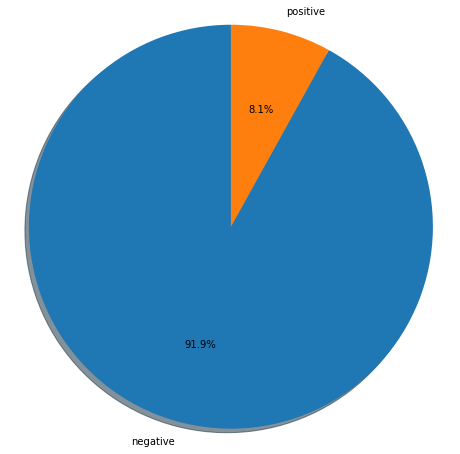

On constate que la classe négative est largement majoritaire (92%). On est en présence d'un dataset déséquillibré.


In [8]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["negative", "positive"]
hist = df["TARGET"].value_counts().values

print("Nombre de sample dans la classe nétative vs positive : \n")

fig1, ax1 = plt.subplots(figsize = (8,8))
ax1.pie(hist, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

print("On constate que la classe négative est largement majoritaire (92%). On est en présence d'un dataset déséquillibré.")

On teste différents modèles de classification : régression linéaire, random forest, xgboost et light-gbm. Il est à noter que s’agissant de modèle de classification, ils implémentent tous la méthode predict_proba qui permet de calculer pour chaque sample sa probabilité d’appartenir à la classe positive. Le score de ce sample est alors simplement définie par la formule suivante :
S = 100*(1-p)

Notre problème de classification binaire présente une particularité, il est déséquilibré (le dataset possède une majorité de client dans la classe négative (92 %). Nous ne pouvons pas appliquer les modèles de machine learning sans en tenir compte. 

C'est pourquoi on intègre des étapes de réequillibrage des classes à notre Pipeline ainsi que le paramètre class_weight.

In [ ]:
# Définition des paramètres du gridsearch
parameters_cv = [{"estimator" : [LogisticRegression(max_iter = 5000)],
                "estimator__class_weight":["balanced", None],
                "estimator__penalty":["l2"]},
                {"estimator" : [RandomForestClassifier()],
                "estimator__n_estimators": [100, 150],
                "estimator__max_depth":[10, 50],
                "estimator__min_samples_leaf":[500, 1000],
                "estimator__class_weight":["balanced"]},
                {"estimator" : [xgb.XGBClassifier()],
                 "estimator__n_estimators": [50, 100],
                 "estimator__max_depth":[10, 20],
                 "estimator__scale_pos_weight":[int(scale_pos)],
                 "estimator__min_samples_leaf":[500, 1000],
                 "estimator__learning_rate":[0.3]},
                {"estimator" : [LGBMClassifier()],
                "estimator__n_estimators":[100, 150],
                "estimator__learning_rate":[0.1],
                "estimator__num_leaves":[500, 1000],
                "estimator__max_depth":[3, 5, 10],
                "estimator__class_weight":["balanced"],
                "estimator__reg_alpha":[0.041545473],
                "estimator__reg_lambda":[0.0735294],
                "estimator__silent":[-1],
                "estimator__verbose":[-1]}]

# Ajout des paramètres de l'oversampling et de l'undersampling
parameter_cv_sampling = add_sampling_to_parameters(parameters_cv[0]) + add_sampling_to_parameters(parameters_cv[1]) + add_sampling_to_parameters(parameters_cv[2]) + add_sampling_to_parameters(parameters_cv[3])

In [ ]:
# Définition de la métrique personalisée
scorer = make_scorer(business_metric_baseline)
metric = scorer

# Initialisation de la pipeline 
preprocessor = StandardScaler()
over = SMOTE()
under = RandomUnderSampler()
pipe = Pipeline([('transformer', preprocessor), ("undersampling", under), ("oversampling", over), ('estimator', LogisticRegression(max_iter=5000))])

# Lancement de l'algorithme d'optimisation des hyperparamètres 
search = GridSearchCV(pipe, parameter_cv_sampling, cv = 3, scoring = metric, return_train_score = True, verbose = 4, n_jobs = 2).fit(X_train, y_train)
y_pred = search.predict(X_test)
y_pred_prob = search.predict_proba(X_test)

# Sauvegarde du model optimal et des resultats
joblib.dump(search.best_estimator_, path_data + 'best_model.pkl')
pd.DataFrame.from_dict(search.cv_results_).to_csv("results_gridsearch.csv", index = False)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV 1/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=balanced, estimator__penalty=l2;, score=(train=0.387, test=0.321) total time=   3.1s
[CV 1/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=None, estimator__penalty=l2;, score=(train=0.388, test=0.324) total time=   3.0s
[CV 3/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=None, estimator__penalty=l2;, score=(train=0.395, test=0.317) total time=   2.9s
[CV 2/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=balanced, estimator__penalty=l2, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.389, test=0.318) total time=  16.7s
[CV 1/3] END estimator=LogisticRegression(max_iter=5000), estimator__class_weight=balanced, estimator__penalty=l2, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[09:51:52] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.

[CV 3/3] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), estimator__learning_rate=0.3, estimator__max_depth=20, estimator__min_samples_leaf=1000, estimator__n_estimators=50, estimator__sc

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), estimator__learning_rate=0.3, estimator__max_depth=20, estimator__min_samples_leaf=1000, estimator__n_estimators=100, estimator__scale_pos_weight=11, oversampling=SMOTE(), oversampling__sampling_strategy=0.3, undersampling=R

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.463, test=0.362) total time=   1.3s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.456, test=0.365) total time=   1.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, sco

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.679, test=0.349) total time=   5.2s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.683, test=0.353) total time=   4.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.685, test=0.348) total time=   6.4s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.684, test=0.335) total time=   6.6s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, 

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.675, test=0.321) total time=   5.1s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;, score=(train=0.677, test=0.346) total time=   4.7s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1;,

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.247, test=0.192) total time=   3.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.424, test=0.351) total time=   1.6s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=1

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.479, test=0.228) total time=   5.5s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.602, test=0.359) total time=   3.0s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=1

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.393, test=0.204) total time=   4.4s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.386, test=0.216) total time=   4.5s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.931, test=0.208) total time=  12.8s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.748, test=0.352) total time=   6.8s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimator

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.750, test=0.344) total time=   7.4s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.745, test=0.358) total time=   7.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.952, test=0.201) total time=  17.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.747, test=0.353) total time=   9.3s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimator

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.937, test=0.202) total time=  14.1s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.743, test=0.342) total time=   6.7s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimat

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=[0.3, 0.7];, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=[0.3, 0.7];, score=(train=nan, test=nan) total time=   0.3s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=100, estimator__num_leav

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.953, test=0.214) total time=  17.2s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=0.751, test=0.340) total time=   9.4s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimato

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 1/3] END estimator=LGBMClassifier(), est

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.346, test=0.285) total time=   2.7s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.3, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=150, estimator__num_leaves=1000, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.3, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 3/3] END estimator=LGBMClassifier(), e

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.555, test=0.289) total time=   4.9s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.3s
[CV 2/3] END estimator=LGBMClassifier(),

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.564, test=0.280) total time=   4.8s
[CV 3/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.561, test=0.295) total time=   4.8s
[CV 2/3] END estimator=LGBMClassifie

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-package

[CV 2/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.3;, score=(train=0.940, test=0.241) total time=  14.8s
[CV 1/3] END estimator=LGBMClassifier(), estimator__class_weight=balanced, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=150, estimator__num_leaves=500, estimator__reg_alpha=0.041545473, estimator__reg_lambda=0.0735294, estimator__silent=-1, estimator__verbose=-1, oversampling=SMOTE(), oversampling__sampling_strategy=0.7, undersampling=RandomUnderSampler(), undersampling__sampling_strategy=0.8;, score=(train=nan, test=nan) total time=   0.4s
[CV 2/3] END estimator=LGBMClassifier(

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_par

In [ ]:
# Résultat de la validation croisée.
results = pd.DataFrame.from_dict(search.cv_results_).sort_values(by = ["mean_test_score"], ascending = False).reset_index(drop = True)
results = results[['param_estimator', 'mean_fit_time', 'mean_train_score', 'mean_test_score']]
results.head()

,param_estimator,mean_fit_time,mean_train_score,mean_test_score
0,"LGBMClassifier(class_weight='balanced', max_de...",1.855972,0.454243,0.368530
1,"LGBMClassifier(class_weight='balanced', max_de...",1.858243,0.461025,0.368164
2,"LGBMClassifier(class_weight='balanced', max_de...",1.274413,0.460292,0.363435
3,"LGBMClassifier(class_weight='balanced', max_de...",1.258001,0.460667,0.362059
4,"LGBMClassifier(class_weight='balanced', max_de...",1.075027,0.438077,0.360686


## Modélisation : Analyse du model

In [ ]:
# Chemin où sont stockées les donées.
path_data = "/content/drive/MyDrive/OPENCLASSROOM/Projet7/"

# Echantillonage pour des raisons de limites de RAM.
n_sample = 100000
df = pd.read_csv(path_data + "df.csv", sep = ",").sample(n = n_sample, random_state = 42)

# Calcul du poids pour le paramètre class_weights. 
scale_pos = df[df["TARGET"]==0].shape[0]/df[df["TARGET"]==1].shape[0]

# Création des arrays pour les données clients et la target. 
X = df.drop(columns = ["TARGET","SK_ID_CURR"]).values
y = df["TARGET"].values

# Split des données en jeu d'entraînement et en jeu de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
# Chargement du modèle optimal et calcul des prédictions de classe et des probas.
warnings.filterwarnings("ignore")
loaded_model = joblib.load(path_data + 'best_model.pkl')
y_pred_test = loaded_model.predict(X_test)
y_pred_proba_test = loaded_model.predict_proba(X_test)

In [ ]:
# Affichage du Pipeline retenu par le gridsearch
print("Affichage du pipeline optimal :\n")
set_config(display="diagram")
loaded_model  # click on the diagram below to see the details of each step

Affichage du pipeline optimal :



Pipeline(steps=[('transformer', StandardScaler()),
                ('undersampling', RandomUnderSampler(sampling_strategy=0.8)),
                ('oversampling', SMOTE()),
                ('estimator',
                 LGBMClassifier(class_weight='balanced', max_depth=3,
                                n_estimators=150, num_leaves=1000,
                                reg_alpha=0.041545473, reg_lambda=0.0735294,
                                silent=-1, verbose=-1))])

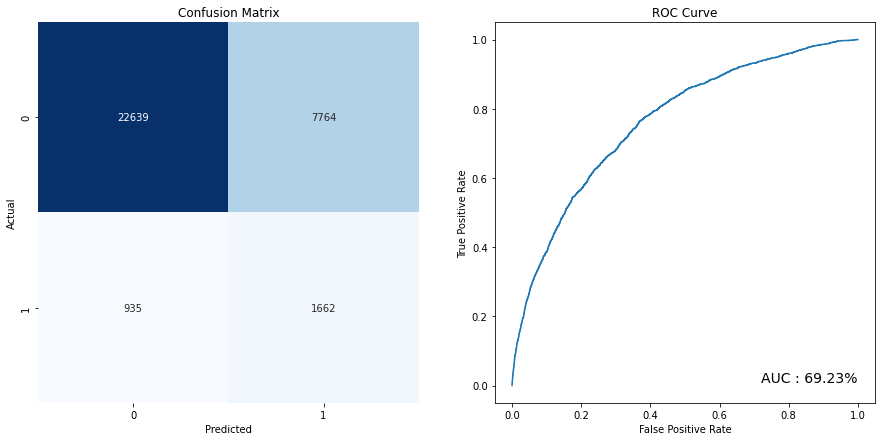

accuracy :  73.64 %
precision :  17.63 %
recall :  64.0 %
f2 :  0.42
personalized_metric (baseline) :  0.341
personalized_metric (normalized) :  0.696
log_loss :  9.1
AUC :  69.23 %


In [ ]:
# Affichage du rapport de la classification
plot_classification_report(y_test, y_pred_test, y_pred_proba_test)

L'optimisation des hyperparamètres grâce à notre métrique personalisée nous a permis d'obtenir une surperformance de près de 70% du worst case scénario (correspondant au maximum de faux négatifs).

# Feature Importance

## Fonctions - Feature Importance

In [10]:
# Fonction d'interprétation locale et globale avec shap

def draw_force_plot(train_data, classifier, transformer, test_data, features_names, train_sample_size = 5000):
  ''' Calcul des valeurs shap et tracé du force plot pour le client dont les inforfations sont fournies par le paramètre test_data.  '''
  train_data_sampled = shap.sample(train_data, train_sample_size, random_state=0)
  explainer = shap.KernelExplainer(classifier.predict_proba, train_data_sampled)
  # explainer = shap.TreeExplainer(classifier)
  reshaped_test_data = test_data.reshape(1,-1)
  shap_values = explainer.shap_values(reshaped_test_data)
  expected_value = explainer.expected_value
  print(expected_value)
  shap.initjs()
  return shap.force_plot(expected_value[0], shap_values[0], reshaped_test_data, feature_names=features_names)

def shap_expected_value(train_data, classifier, transformer, test_data, features_names, train_sample_size = 5000):
  ''' Calcul de l'expected value'''
  train_data_sampled = shap.sample(train_data, train_sample_size, random_state=0)
  explainer = shap.KernelExplainer(classifier.predict_proba, train_data_sampled)
  expected_value = explainer.expected_value
  return expected_value

def shap_interpretation(train_data, classifier, transformer, test_data, features_names, train_sample_size = 5000):
  ''' Calcul des valaurs shap et de l'expected value'''
  train_data_sampled = shap.sample(train_data, train_sample_size, random_state=0)
  explainer = shap.KernelExplainer(classifier.predict_proba, train_data_sampled)
  # explainer = shap.TreeExplainer(classifier)
  reshaped_test_data = test_data.reshape(1,-1)
  shap_values = explainer.shap_values(reshaped_test_data)
  expected_value = explainer.expected_value
  return {"shap_values" : shap_values, "expected_value" : expected_value}



## Local feature importance

On va procéder en entrainant l’explainer en choisissant de manière astucieuse le background dataset : on ne choisit que des clients de la classe négative. On va ensuite tracer un force plot qui a pour but d’expliquer l’écart entre l’output du model pour une prédiction et la valeur attendue

In [11]:
# Définition du background dataset
neg_idx = np.where(y_test == 0)
X_train_neg = X_train[neg_idx]
y_train_neg = y_train[neg_idx]

In [16]:
# Chargement du modèle et du background dataset
loaded_model = joblib.load(path_data + 'best_model.pkl')
scaler = loaded_model["transformer"]
train_data = X_train_neg
features_names = df.drop(columns = ["SK_ID_CURR", "TARGET"]).columns
pi = 20
test_data = X_test[pi]
train_sample_size = 200

On vérifie que les valeurs attendues (expected values) sont proches de la moyenne des prédictions du background dataset :

In [17]:
print("expected_value : ", shap_expected_value(train_data = train_data, classifier = loaded_model, transformer = scaler, test_data = test_data, features_names = features_names, train_sample_size = train_sample_size))
print("mean_prediction : ", loaded_model.predict_proba(train_data).mean(axis=0))

expected_value :  [0.63102774 0.36897226]
mean_prediction :  [0.6177944 0.3822056]


In [ ]:
# Exemple de force plot pour un bon et un mauvais client
pred_ind = [20, 18]
for pi in pred_ind:
    test_data = X_test[pi]
    msg = "good_client :\n" if pi == 20 else "bad_client :\n"
    print(msg)
    display(draw_force_plot(train_data = train_data, classifier = loaded_model, transformer = scaler, test_data = test_data, features_names = features_names, train_sample_size = train_sample_size))

good_client :



  0%|          | 0/1 [00:00<?, ?it/s]

[0.63102774 0.36897226]


bad_client :



  0%|          | 0/1 [00:00<?, ?it/s]

[0.63102774 0.36897226]


Ces graphiques nous permettent d'expliquer en termes de features l'écart entre le score d'un client et le score moyen des clients de la classe négative (les "bons clients"). Ainsi, on apprend par exemple dans le graphique du haut que le fait que le client soit une femme (Code Gender = 1) a eu une influance positive sur le score ou encore que son age (28 ans) a eu une influance négative.

## Global feature importance

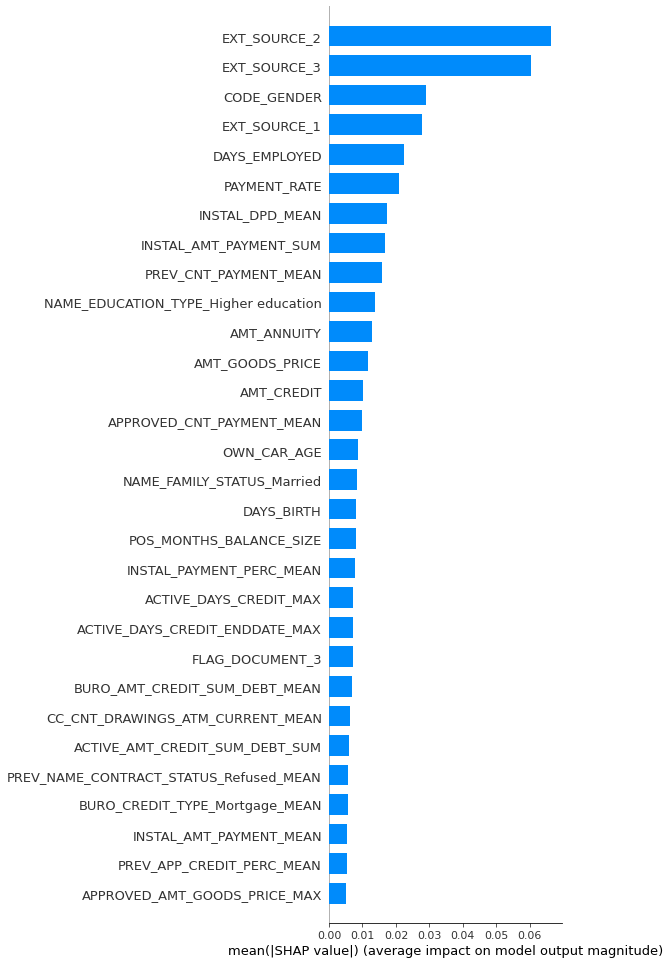

In [25]:
# Calcul de la feature importance globale du modèle
train_sample_size = 100
scaler = loaded_model[0].fit(X_train)
X_train_std = scaler.transform(X_train)
train_data_sampled = shap.sample(X_train_std, train_sample_size, random_state=0)
explainer = shap.KernelExplainer(loaded_model.predict_proba, train_data_sampled)
model = loaded_model[3].fit(X_train_std, y_train)
explainer = shap.TreeExplainer(model, data = X_train_std, feature_perturbation = "interventional", model_output = "probability")
X_test_std = scaler.transform(X_test)
shap_values = explainer.shap_values(X_test_std)
features_names = df.drop(columns = ["SK_ID_CURR", "TARGET"]).columns
shap.summary_plot(shap_values, feature_names=features_names, plot_type='bar',max_display = 30)